In [24]:
# 29 Jan 2019
# generates the NEMO vertical grid using the Madec & Imbard 96 formulation

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

In [111]:
# function to mimic the Madec & Imbard 1996 formulation
#
# to put in double tanh formulation?

def gen_nemo_zgr(jpkglo, params, config = ""):
    
    """
    Generates a vertical grid using the Madec & Imbard (1996) formulation. Give the following:
    
    Inputs
        jpkglo                number of levels
        params["zacr"]        stretching factor (nondimensional) h_cr large = smal stretching, h_cr in NEMO book
        params["zkth"]        pproximately the model level at which maximum stretching occur, h_th in NEMO book
        
        either
            params["zsur"]    ppsur, h_sur in NEMO book (opt)
            params["za0"]     ppa0 , h_0   in NEMO book (opt)
            params["za1"]     ppa1 , h_1   in NEMO book (opt)
        or
            params["zdzmin"]  Minimum vertical spacing
            params["zhmax"]   Maximum depth
    
    Optional
        Specify third argument config = "ORCA", "EEL" etc. for some default options
        
        
    Outputs
        gdepw_1d, gdept_1d, e3w_1d, e3t_1d
    """
    
    if config.upper() == "ORCA2":
        jpkglo = 31
        zsur   =-4762.96143546300
        za0    =  255.58049070440
        za1    =  245.58132232490
        zacr   =    3.0
        zkth   =   21.43336197938
        print("using ORCA2 configuration with %i levels" % jpkglo)
    elif config.upper() == "EEL":
        jpkglo = 31
        zsur   =-2033.194295283385
        za0    =  155.8325369664153
        za1    =  146.3615918601890
        zacr   =    5.0
        zkth   =   17.28520372419791
    else:
        print("using custom configuration with %i levels" % jpkglo)
        try:
            zacr, zkth, zdzmin, zhmax = params["zacr"], params["zkth"], params["zdzmin"], params["zhmax"]
        except KeyError:
            print("one of zacr, zkth, zdzmin, zhmax not defined, check")
            return (0.0, 0.0, 0.0, 0.0)

        if (params["zsur"] is None or params["za1"] is None or params["za0"] is None):
            print("zur, za0 or za1 not imposed, recalculating the coefficients")
            za1 = (      ( zdzmin - zhmax / (jpkglo - 1.0) ) 
                       / ( np.tanh( (1.0 - zkth) / zacr) 
                          - zacr / (jpkglo - 1.0) * (  np.log( np.cosh( (jpkglo - zkth) / zacr) )
                                                     - np.log( np.cosh( (1.0    - zkth) / zacr) )  
                                                     )   
                         )    
                  )
            za0  = zdzmin - za1        *         np.tanh( (1.0 - zkth) / zacr  )
            zsur =   -za0 - za1 * zacr * np.log( np.cosh( (1.0 - zkth) / zacr) )
        else:
            zsur, za1, za2 = params["zsur"], params["za1"], params["za2"]
        
    gdepw_1d, gdept_1d = np.zeros(jpkglo), np.zeros(jpkglo)
    e3w_1d, e3t_1d = np.zeros(jpkglo), np.zeros(jpkglo)

    zw = np.float32(np.arange(1, jpkglo + 1))
    zt = np.float32(np.arange(1, jpkglo + 1)) + 0.5

    gdepw_1d = zsur + za0 * zw + za1 * zacr * np.log (  np.cosh( (zw - zkth) / zacr )  )
    gdept_1d = zsur + za0 * zt + za1 * zacr * np.log (  np.cosh( (zt - zkth) / zacr )  )
    e3w_1d   =        za0      + za1        * np.tanh(           (zw - zkth) / zacr )
    e3t_1d   =        za0      + za1        * np.tanh(           (zt - zkth) / zacr )
    gdepw_1d[0] = 0.0
    
    return(gdepw_1d, gdept_1d, e3w_1d, e3t_1d)

using ORCA2 configuration with 31 levels


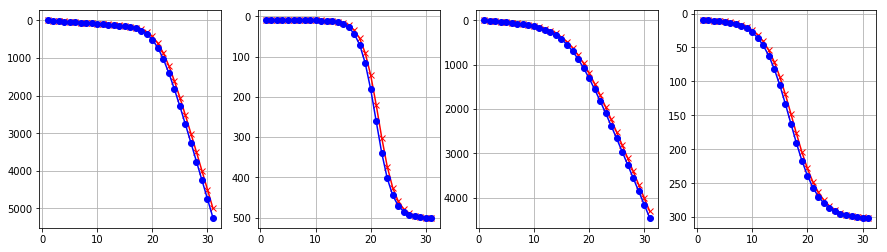

In [112]:
# ORCA2 config testing

params = {"zsur"   : None,           # ppsur, h_sur in NEMO book
          "za0"    : None,           # ppa0 , h_0   in NEMO book
          "za1"    : None,           # ppa1 , h_1   in NEMO book
          "zacr"   : 3.0,            # stretching factor (nondimensional) h_cr large = smal stretching, h_cr in NEMO book
          "zkth"   : 21.43336197938, # pproximately the model level at which maximum stretching occur, h_th in NEMO book
          "zdzmin" : 10.0,           # Minimum vertical spacing
          "zhmax"  : 5000.0          # Maximum depth
         }

jpkglo = 31

gdepw_1d, gdept_1d, e3w_1d, e3t_1d = gen_nemo_zgr(jpkglo, params, config = "ORCA2")

fig = plt.figure(figsize = (15, 4))
plt.subplot(1, 4, 1)
plt.plot(np.arange(1, jpkglo + 1), gdepw_1d, 'rx-', np.arange(1, jpkglo + 1), gdept_1d, 'bo-')
plt.gca().invert_yaxis()
plt.grid()
plt.subplot(1, 4, 2)
plt.plot(np.arange(1, jpkglo + 1), e3w_1d, 'rx-', np.arange(1, jpkglo + 1), e3t_1d, 'bo-')
plt.gca().invert_yaxis()
plt.grid()

gdepw_1d, gdept_1d, e3w_1d, e3t_1d = gen_nemo_zgr(jpkglo, params, config = "EEL")

plt.subplot(1, 4, 3)
plt.plot(np.arange(1, jpkglo + 1), gdepw_1d, 'rx-', np.arange(1, jpkglo + 1), gdept_1d, 'bo-')
plt.gca().invert_yaxis()
plt.grid()
plt.subplot(1, 4, 4)
plt.plot(np.arange(1, jpkglo + 1), e3w_1d, 'rx-', np.arange(1, jpkglo + 1), e3t_1d, 'bo-')
plt.gca().invert_yaxis()
plt.grid()

using custom configuration with 31 levels
zur, za0 or za1 not imposed, recalculating the coefficients


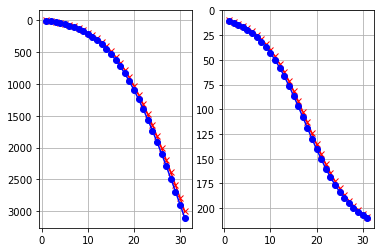

In [113]:
# custom config testing

params = {"zsur"   : None,      # ppsur, h_sur in NEMO book
          "za0"    : None,      # ppa0 , h_0   in NEMO book
          "za1"    : None,      # ppa1 , h_1   in NEMO book
          "zacr"   : 10.0,      # stretching factor (nondimensional) h_cr large = smal stretching, h_cr in NEMO book
          "zkth"   : 18.0,      # pproximately the model level at which maximum stretching occur, h_th in NEMO book
          "zdzmin" : 10.0,      # Minimum vertical spacing
          "zhmax"  : 3000.0     # Maximum depth
         }

jpkglo = 31

gdepw_1d, gdept_1d, e3w_1d, e3t_1d = gen_nemo_zgr(jpkglo, params)

plt.subplot(1, 2, 1)
plt.plot(np.arange(1, jpkglo + 1), gdepw_1d, 'rx-', np.arange(1, jpkglo + 1), gdept_1d, 'bo-')
plt.gca().invert_yaxis()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, jpkglo + 1), e3w_1d, 'rx-', np.arange(1, jpkglo + 1), e3t_1d, 'bo-')
plt.gca().invert_yaxis()
plt.grid()


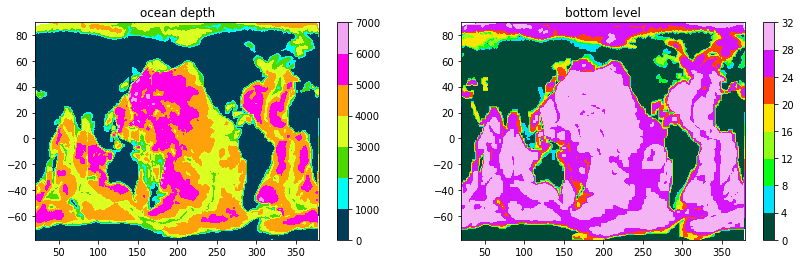

In [45]:
# check and make sure the convention with getting bathymetry level is the same

data = Dataset("/home/julian/NEMO/trunk/NEMOGCM/TOOLS/DOMAINcfg/testing_ORCA2/bathy_level.nc")
bathy_lv_ORCA2 = data.variables["Bathy_level"][:, :]
data.close()

data = Dataset("/home/julian/NEMO/trunk/NEMOGCM/TOOLS/DOMAINcfg/testing_ORCA2/bathy_meter.nc")
lon, lat = data.variables["nav_lon"][:, :], data.variables["nav_lat"][:, :]
bathy_me_ORCA2 = data.variables["Bathymetry"][:, :]
data.close()

bathy_lv_ORCA2[bathy_lv_ORCA2 <= 0] = 0

fig = plt.figure(figsize = (14, 4))
plt.subplot(1, 2, 1)
plt.tricontourf(lon.flatten(), lat.flatten(), bathy_me_ORCA2.flatten(), cmap = "gist_ncar")
plt.title("ocean depth")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.tricontourf(lon.flatten(), lat.flatten(), bathy_lv_ORCA2.flatten(), cmap = "gist_ncar")
plt.title("bottom level")
plt.colorbar()

AttributeError: module 'matplotlib.pyplot' has no attribute 'caxis'

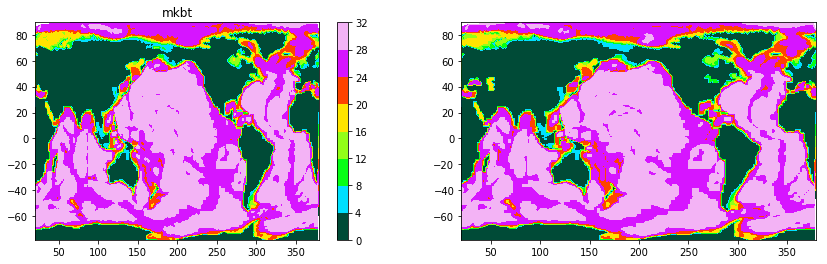

In [93]:
jpjglo, jpiglo = bathy_me_ORCA2.shape[0], bathy_me_ORCA2.shape[1]
mbkt = np.zeros((jpjglo, jpiglo))
for jj in range(jpjglo):
    for ji in range(jpiglo):
        if ~(bathy_me_ORCA2[jj, ji] < gdept_1d).any(): # very deep levels, just give it the bottom index
            mbkt[jj, ji] = jpkglo - 1.0
        else:
            mbkt[jj, ji] = np.argmax(bathy_me_ORCA2[jj, ji] < gdept_1d)
        
fig = plt.figure(figsize = (14, 4))
plt.subplot(1, 2, 1)
plt.tricontourf(lon.flatten(), lat.flatten(), mbkt.flatten(), cmap = "gist_ncar")
plt.title("mkbt")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.tricontourf(lon.flatten(), lat.flatten(), bathy_lv_ORCA2.flatten(), cmap = "gist_ncar")
plt.title("truth of sorts")
plt.colorbar()


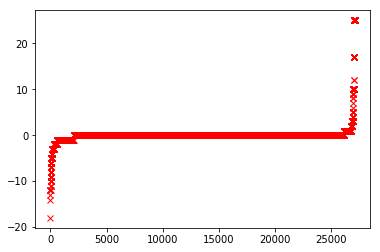

In [94]:
plt.plot(np.sort(bathy_lv_ORCA2.flatten() - mbkt.flatten()), 'rx')


using custom configuration with 31 levels
zur, za0 or za1 not imposed, recalculating the coefficients


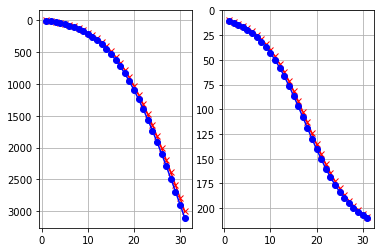